# Lorenz 63

In this notebook we'll simulate a Lorenz system. The definition of the model is given by

\begin{align}
    \dot{x} & = \sigma(y-x), \\
    \dot{y} & = \rho x - y - xz, \\
    \dot{z} & = -\beta z + xy,
\end{align}

where $\dot{x}$ denotes a time derivative. The above model is an ODE in three variables. `stochproc` is designed for stochastic processes, and therefore we need to recast the model into a stochastic process form by introducing an artifical noise process as in TODO.

\begin{align}
    X_{t + \Delta t} & = g_x(X_t, Y_t, Z_t; \sigma) + \tau W^x_{t + \Delta t}, \\
    Y_{t + \Delta t} & = g_y(X_t, Y_t, Z_t; \rho) + \tau W^y_{t + \Delta t}, \\
    Z_{t + \Delta t} & = g_z(X_t, Y_t, Z_t; \beta) + \tau W^z_{t + \Delta t},
\end{align}

where we let $g_j$ denote the RK4 method applied to the RHS of the first equations, $W^i_t \sim \mathcal{N}(0, \Delta t)$, and $\tau > 0$ a tuning parameter. Translating this to `stochproc` yields

In [1]:
from stochproc import timeseries as ts, distributions as dists, NamedParameter
import torch


def f(x, s, r, b):
    x1 = s * (x.values[..., 1] - x.values[..., 0])
    x2 = r * x.values[..., 0] - x.values[..., 1] - x.values[..., 0] * x.values[..., 2]
    x3 = - b * x.values[..., 2] + x.values[..., 0] * x.values[..., 1]

    return torch.stack((x1, x2, x3), dim=-1)


initial_values = torch.tensor([-5.91652, -5.52332, 24.5723])

s = NamedParameter("sigma", 10.0)
r = NamedParameter("rho", 28.0)
b = NamedParameter("beta", 8.0 / 3.0)

tau = 1e-2
dt = 1e-2

model = ts.RungeKutta(f, (s, r, b), initial_values, dt=dt, event_dim=1, tuning_std=tau)

We then sample some time steps and plot the resulting trajectory.

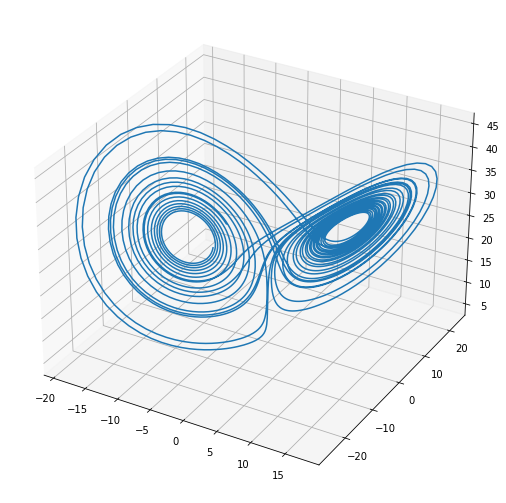

In [2]:
import matplotlib
import matplotlib.pyplot as plt

x = model.sample_path(3_000)
array = x.numpy()

fig = plt.figure(figsize=(16, 9))
ax = plt.axes(projection='3d')

ax.plot3D(array[:, 0], array[:, 1], array[:, 2])

However, what if we just received the observed data together with the model definition, and no parameters? `pyro` to the rescue! We may utilize `pyro` for inferring the parameters given the observed data easily pretty smoothly, see below.

In [3]:
import pyro
from pyro.distributions import LogNormal, Uniform
import tqdm

def lorenz_probabilistic(data, verbose=False):
    s = pyro.sample("sigma", Uniform(low=5.0, high=40.0))
    r = pyro.sample("rho", Uniform(low=10.0, high=50.0))
    b = pyro.sample("beta", Uniform(low=1.0, high=20.0))
    
    model = ts.RungeKutta(f, (s, r, b), initial_values, dt=dt, event_dim=1, tuning_std=tau)
    model.do_sample_pyro(pyro, data.shape[0], obs=data)

    return


guide = pyro.infer.autoguide.AutoDiagonalNormal(lorenz_probabilistic)
optim = pyro.optim.Adam({"lr": 0.01})
svi = pyro.infer.SVI(lorenz_probabilistic, guide, optim, loss=pyro.infer.Trace_ELBO())

niter = 10_000
pyro.clear_param_store()

running_average = 0.0
smoothing = 0.99

bar = tqdm.tqdm(range(niter))
for n in bar:
    loss = svi.step(x)
    
    running_average = smoothing * running_average + (1 - smoothing) * loss
    bar.set_description(f"Loss: {running_average:,.2f}")

Loss: 508,898.53: 100%|█████████████████████████████████████████████████████████| 10000/10000 [01:24<00:00, 118.51it/s]


Finally, let's plot the distributional parameters.

array([<AxesSubplot:title={'center':'sigma'}>,
       <AxesSubplot:title={'center':'rho'}>,
       <AxesSubplot:title={'center':'beta'}>], dtype=object)

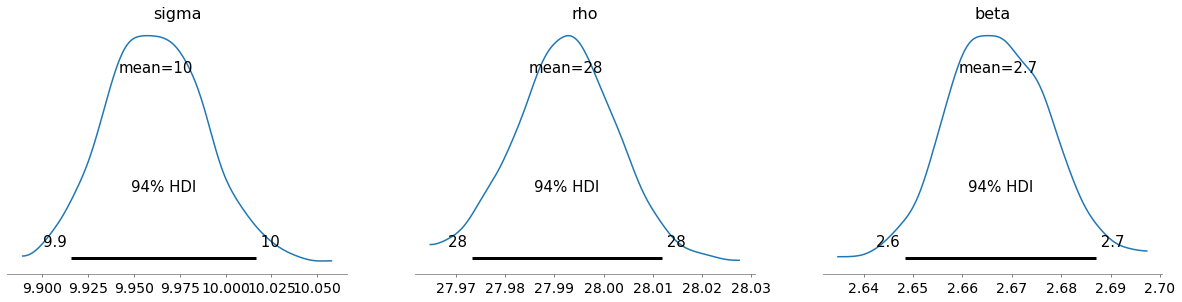

In [4]:
import arviz
import pandas as pd

num_samples = 1_000
posterior_predictive = pyro.infer.Predictive(
    lorenz_probabilistic,
    guide=guide,
    num_samples=num_samples
)

posterior_draws = {k: v.unsqueeze(0) for k, v in posterior_predictive(x).items()}

posteriors = arviz.from_dict(posterior_draws)
arviz.plot_posterior(posteriors, var_names=["sigma", "rho", "beta"])

From the above plot we clearly see that `pyro` has correctly identified the parameter values.